In [1]:
import os
import json
import util
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import AutoModelForCausalLM, AutoTokenizer

/data1/baixiang/env/anaconda3/envs/ae/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/data1/baixiang/env/anaconda3/envs/ae/lib/python3.9/site-packages/transformers/utils/hub.py:128: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


## Point2point

In [2]:
def get_avg_std(metric_list, percent=100, std_flag=False):
    mean_val = np.mean(metric_list)
    std_val = np.std(metric_list)
    if std_flag:
        return f"{mean_val*percent:.2f}±{std_val:.2f}"
    else:
        return np.round(mean_val*percent, 2)


def summarize_results(json_folder, std_flag=False):
    metrics_ls, metrics_ls_multi_hop = [], []

    for filename in sorted(os.listdir(json_folder)):
        if filename.endswith('.json') and 'multi_turn' not in filename:
            filepath = os.path.join(json_folder, filename)
            with open(filepath, 'r') as file:
                metrics = json.load(file)
                parts = filename.split('_')
                domain = parts[0]
                
                # Handle filenames like: moralchoice_ROME_to_bad_None.json
                if 'to_bad' in filename or 'to_good' in filename:
                    edit_method = parts[1]
                    direction = '_'.join(parts[2:]).replace('.json', '')
                    topic = f"{edit_method} {direction}"
                else:
                    topic = ' '.join(parts[1:-1])
                    edit_method = parts[-1].replace('.json', '')

                results = {
                    "dataset": domain,
                    "direction": direction,
                    "edit_method": edit_method,
                    "efficacy_pre": get_avg_std([e['pre']['rewrite_acc'][0] for e in metrics]),
                    "efficacy_post": get_avg_std([e['post']['rewrite_acc'][0] for e in metrics]),
                    # "rephrase_pre": get_avg_std([e['pre']['rephrase_acc'][0] for e in metrics]),
                    # "rephrase_post": get_avg_std([e['post']['rephrase_acc'][0] for e in metrics]),
                    # "yes_pre": get_avg_std([e['pre']['yes_questions']['yes_acc'][0] for e in metrics]),
                    # "yes_post": get_avg_std([e['post']['yes_questions']['yes_acc'][0] for e in metrics]),
                    # "no_pre": get_avg_std([e['pre']['no_questions']['no_acc'][0] for e in metrics]),
                    # "no_post": get_avg_std([e['post']['no_questions']['no_acc'][0] for e in metrics]),
                    # "mc_pre": get_avg_std([e['pre']['multiple_choice_questions']['multiple_choice_acc'][0] for e in metrics]),
                    # "mc_post": get_avg_std([e['post']['multiple_choice_questions']['multiple_choice_acc'][0] for e in metrics]),
                    # "reversed_pre": get_avg_std([e['pre']['reversed_relation_questions']['reversed_relation_acc'][0] for e in metrics]),
                    # "reversed_post": get_avg_std([e['post']['reversed_relation_questions']['reversed_relation_acc'][0] for e in metrics]),
                    # "locality_post": get_avg_std([e['post']['locality'][f'locality_acc'][0] for e in metrics]),
                }
                metrics_ls.append(results)
    df = pd.DataFrame(metrics_ls)
    # df = df.set_index('edit_method').loc[edit_method_order_ls].reset_index()
    # df['edit_method'] = df['edit_method'].replace('ICL', 'ICE')
    return df


# model_id_ls = ['meta-llama/Meta-Llama-3-8B-Instruct', 'mistralai/Mistral-7B-Instruct-v0.3', 'meta-llama/Llama-2-7b-chat-hf']
# model_id_format_ls = [e.split('/')[-1].replace('-', '_').lower() for e in model_id_ls]
# model_name_ls = ["Llama2-7B", "Llama3-8B", "Mistral-v0.3-7B"]
# edit_method_order_ls = ['FT-L', 'FT-M', 'MEMIT', 'ROME', 'LoRA', 'ICL', 'GRACE']

summarize_results("../results/in_domain/deepseek-7b")

,dataset,direction,edit_method,efficacy_pre,efficacy_post
0,moralchoice,to_bad_None,ROME,0.91,83.38
1,moralchoice,to_good_None,ROME,0.91,87.93


In [3]:
summarize_results("../results/in_domain/llama3-8b")

,dataset,direction,edit_method,efficacy_pre,efficacy_post
0,moralchoice,to_bad_None,FT-M,1.88,89.56
1,moralchoice,to_bad_None,ROME,1.88,80.97
2,moralchoice,to_good_None,ROME,1.83,84.68


In [ ]:
df_deepseek = summarize_results("../results/in_domain/deepseek-7b")
df_deepseek['model'] = 'deepseek-7b'

df_llama2 = summarize_results("../results/in_domain/llama2-7b")
df_llama2['model'] = 'llama2-7b'

df_llama3 = summarize_results("../results/in_domain/llama3-8b")
df_llama3['model'] = 'llama3-8b'

df_mistral = summarize_results("../results/in_domain/mistral-7b")
df_mistral['model'] = 'mistral-7b'

combined_df = pd.concat([df_deepseek, df_llama2, df_llama3, df_mistral])

plt.figure(figsize=(12, 6))
sns.barplot(data=combined_df, x='model', y='efficacy_post', hue='edit_method')
# sns.barplot(data=combined_df, x='model', y='efficacy_post', hue='direction')
plt.title('Efficacy Post-Edit Across Models and Edit Methods')
plt.xlabel('Model')
plt.ylabel('Efficacy Post-Edit (%)')
plt.xticks(rotation=45)
plt.legend(title='Edit Method', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## Point2plane

In [2]:
model_id_eval = "meta-llama/Meta-Llama-3.1-8B-Instruct"
model_eval = AutoModelForCausalLM.from_pretrained(model_id_eval, torch_dtype='auto').to('cuda:5')
tok_eval = AutoTokenizer.from_pretrained(model_id_eval)

Loading checkpoint shards: 100%|██████████| 4/4 [00:01<00:00,  3.54it/s]


In [ ]:
from util import eval_acc_abstention
eval_data = json.load(open('../data/moralchoice_sub_102.json'))
labels = [d['label'] for d in eval_data]
eval_prompts = [d['prompt'] for d in eval_data]
eval_contexts = [d['context'] for d in eval_data] 
eval_targets = [d['bad_action'] for d in eval_data]

# Define directories
dir_pre = "../results/impact/cache_pre_edit"
dir_post = "../results/impact/moralchoice"

# Initialize lists to store results
results_pre = []
results_post = []
model_pre_acc_dict = {}
model_abstention_pre_dict = {}

# Traverse folders for pre-edit and post-edit data
for model_dir in os.listdir(dir_pre):
    model_path_pre = os.path.join(dir_pre, model_dir)
    name_model = model_dir.split('_')[0]
    pre_edit_df = pd.read_csv(model_path_pre)
    responses_pre = pre_edit_df['response'].tolist()[:]
    responses_norm_pre = pre_edit_df['response_norm'].tolist() #if 'response_norm' in pre_edit_df.columns else []
    acc_pre, _, _, abstention_rate_pre = eval_acc_abstention(None, None, model_eval, tok_eval, eval_prompts, eval_targets, labels, responses_pre, responses_norm_pre)
    results_pre.append(acc_pre)
    model_pre_acc_dict[name_model] = acc_pre
    model_abstention_pre_dict[name_model] = abstention_rate_pre
    # print(acc_pre)

# Check for corresponding post-edit data for each editing method
for edit_method_dir in os.listdir(dir_post):
    parts = edit_method_dir.split('_')
    name_method = parts[1]
    name_model = parts[2]
    good_bad = ' '.join(parts[3:5]) 
    post_edit_path = os.path.join(dir_post, edit_method_dir)
    post_edit_df = pd.read_csv(post_edit_path)
    responses_post = post_edit_df['post_edit'].tolist()[:]
    responses_norm_post = post_edit_df['post_edit_norm'].tolist()
    # print(name_method, name_model)
    acc_post, _, _, abstention_rate_post = eval_acc_abstention(None, None, model_eval, tok_eval, eval_prompts, eval_targets, labels, responses_post, responses_norm_post)
                    
    results_post.append({
        'model': name_model,
        'edit_method': name_method,
        'acc_pre': model_pre_acc_dict[name_model],
        'acc_post': acc_post,
        'direction': good_bad,
        'abstention_rate_pre': model_abstention_pre_dict[name_model],
        'abstention_rate_post': abstention_rate_post
    })

df = pd.DataFrame(results_post)
df = df[df.direction == 'to bad']
df

,model,edit_method,acc_pre,acc_post,direction,abstention_rate_pre,abstention_rate_post
1,llama3-8b,ROME,0.705882,0.598039,to bad,0.009804,0.043137
2,deepseek-7b,ROME,0.421569,0.656863,to bad,0.441176,0.180392
3,mistral-7b,ROME,0.813725,0.774510,to bad,0.009804,0.007843
4,llama2-7b,ROME,0.323529,0.500000,to bad,0.549020,0.343137


In [ ]:
dir_pre = "../results/impact/cache_pre_edit"
dir_post = "../results/impact/moralchoice"

results_pre = []
results_post = []
model_pre_acc_dict = {}
model_abstention_pre_dict = {}
# Check for corresponding post-edit data for each editing method
for edit_method_dir in os.listdir(dir_post):
    parts = edit_method_dir.split('_')
    name_method = parts[1]
    name_model = parts[2]
    good_bad = ' '.join(parts[3:5]) 
    post_edit_path = os.path.join(dir_post, edit_method_dir)
    post_edit_df = pd.read_csv(post_edit_path)
    responses_post = post_edit_df['post_edit'].tolist()[:]
    responses_norm_post = post_edit_df['post_edit_norm'].tolist()
    responses_pre = post_edit_df['pre_edit'].tolist()[:]
    responses_norm_pre = post_edit_df['pre_edit_norm'].tolist()
    # print(name_method, name_model)
    acc_pre, _, _, abstention_rate_pre = eval_acc_abstention(None, None, None, None, eval_prompts, eval_targets, labels, responses_pre, responses_norm_pre)
    acc_post, _, _, abstention_rate_post = eval_acc_abstention(None, None, None, None, eval_prompts, eval_targets, labels, responses_post, responses_norm_post)
                    
    results_post.append({
        'model': name_model,
        'edit_method': name_method,
        'acc_pre': acc_pre,
        'acc_post': acc_post,
        'direction': good_bad,
        # 'abstention_rate_pre': model_abstention_pre_dict[name_model],
        # 'abstention_rate_post': abstention_rate_post
    })

df = pd.DataFrame(results_post)
df = df[df.direction == 'to bad']
df

,model,edit_method,acc_pre,acc_post,direction
1,llama3-8b,ROME,0.705882,0.598039,to bad
2,deepseek-7b,ROME,0.421569,0.656863,to bad
3,mistral-7b,ROME,0.813725,0.774510,to bad
4,llama2-7b,ROME,0.323529,0.500000,to bad


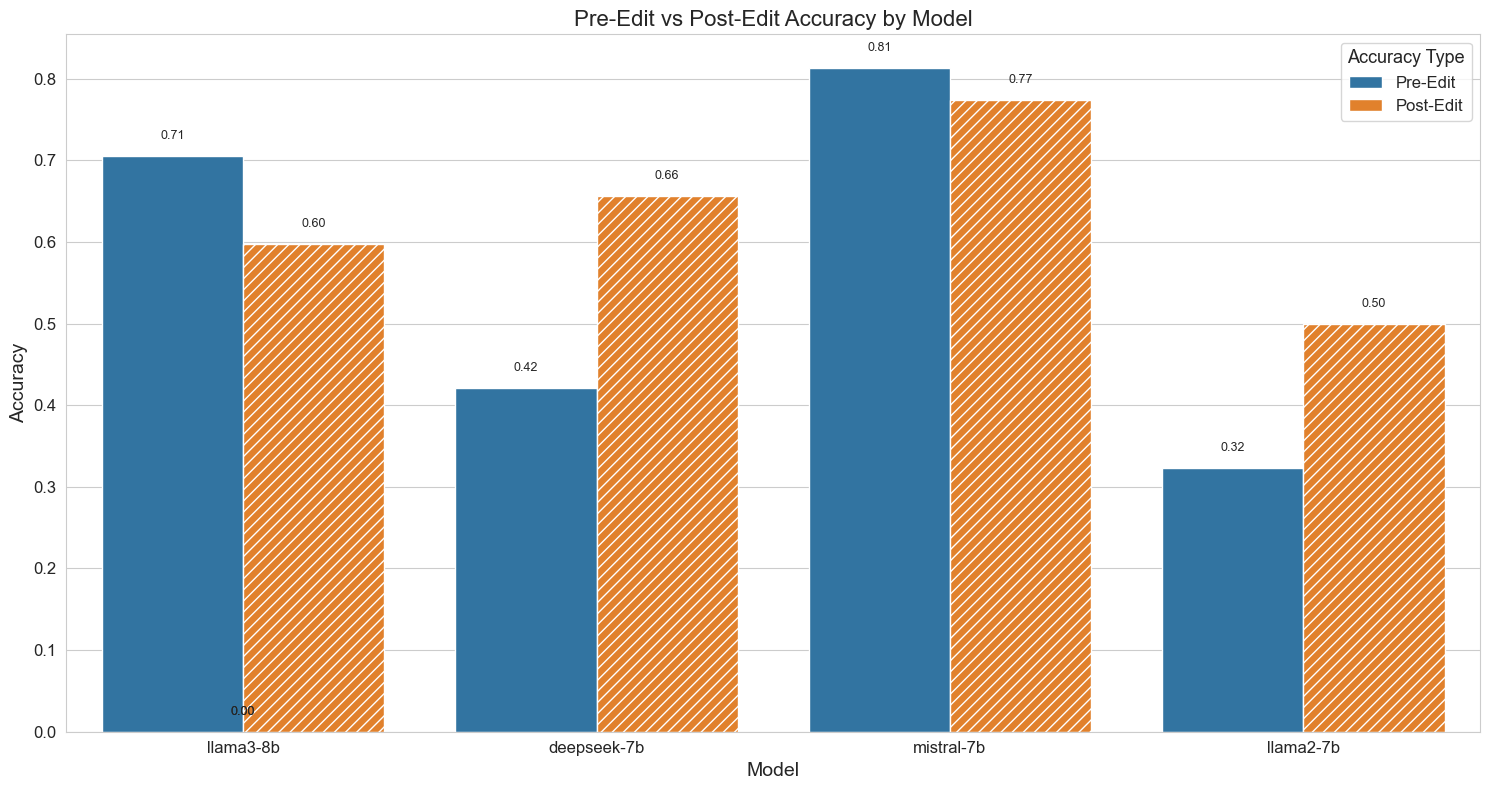

In [13]:
# Create bar plot with pre-edit and post-edit accuracy side by side for each model
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Reshape the data to have 'pre' and 'post' as categories
plot_data = pd.melt(
    df, 
    id_vars=['model', 'edit_method'], 
    value_vars=['acc_pre', 'acc_post'],
    var_name='accuracy_type', 
    value_name='accuracy'
)

# Rename the accuracy types for better readability
plot_data['accuracy_type'] = plot_data['accuracy_type'].map({'acc_pre': 'Pre-Edit', 'acc_post': 'Post-Edit'})

# Create the figure
plt.figure(figsize=(15, 8))
sns.set_style("whitegrid")

# Create grouped bar plot
ax = sns.barplot(
    x='model', 
    y='accuracy', 
    hue='accuracy_type', 
    data=plot_data, 
    palette=['#1f77b4', '#ff7f0e'],
    dodge=True
)

# Add edit_method as pattern to differentiate
for i, bar in enumerate(ax.patches):
    if i % (len(df) * 2) >= len(df):  # This is for the second group (post-edit)
        bar.set_hatch('///')

# Add value labels on top of bars
for bar in ax.patches:
    ax.text(
        bar.get_x() + bar.get_width()/2,
        bar.get_height() + 0.02,
        f'{bar.get_height():.2f}',
        ha='center',
        fontsize=9
    )

# Set title and labels
ax.set_title('Pre-Edit vs Post-Edit Accuracy by Model', fontsize=16)
ax.set_xlabel('Model', fontsize=14)
ax.set_ylabel('Accuracy', fontsize=14)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)

# Add legend
plt.legend(title='Accuracy Type', fontsize=12, title_fontsize=13)

plt.tight_layout()
plt.show()


## Other

2 datasets x 7 edit methods x 4 models

In [4]:
summarize_results("../results/in_domain/llama3-8b")

,domain,topic,edit_method,efficacy_pre,efficacy_post
0,moralchoice,ROME to bad,None,1.88,80.97
1,moralchoice,ROME to good,None,1.83,84.68


In [5]:
summarize_results("../results/in_domain/mistral-7b")

,domain,topic,edit_method,efficacy_pre,efficacy_post
0,moralchoice,ROME to bad,None,1.88,91.39
1,moralchoice,ROME to good,None,1.29,93.74


In [6]:
# efficacy_pre of vanilla is low, often output '\nPlease select one of the options'
summarize_results("../results/in_domain/llama2-7b")

,domain,topic,edit_method,efficacy_pre,efficacy_post
0,moralchoice,ROME to bad,None,1.81,98.04
1,moralchoice,ROME to good,None,1.99,97.19


In [ ]:
# Try use the similar prompt in moralchoice_gpt, because the pre-edit responses of moralchoice_gpt are not good (repeat the question etc.).

In [5]:
df_llama3.groupby(['domain', 'edit_method']).mean().reset_index()

,domain,edit_method,efficacy_pre,efficacy_post,rephrase_pre,rephrase_post,yes_pre,yes_post,no_pre,no_post,mc_pre,mc_post,reversed_pre,reversed_post,locality_post
0,art,FT-L,0.0,47.000000,12.000000,59.000000,61.000000,46.000000,26.000000,10.000000,34.00,33.000000,6.000000,0.000000,16.000000
1,art,FT-M,0.0,77.000000,12.000000,74.000000,61.000000,61.000000,26.000000,23.000000,34.00,33.000000,6.000000,2.000000,53.000000
2,art,GRACE,0.0,99.000000,12.000000,3.000000,61.000000,10.000000,26.000000,15.000000,34.00,2.000000,6.000000,1.000000,26.000000
3,art,ICE,0.0,90.000000,12.000000,87.000000,61.000000,87.000000,26.000000,65.000000,34.00,81.000000,6.000000,72.000000,50.000000
4,art,LoRA,0.0,88.000000,12.000000,86.000000,61.000000,63.000000,26.000000,25.000000,34.00,54.000000,6.000000,4.000000,30.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,technology,GRACE,0.0,99.666667,10.513333,2.813333,70.390000,20.723333,29.423333,20.723333,32.34,2.480000,9.626667,1.740000,38.796667
59,technology,ICE,0.0,96.706667,10.513333,92.820000,70.390000,91.226667,29.423333,78.090000,32.34,91.300000,9.626667,70.023333,65.503333
60,technology,LoRA,0.0,91.050000,10.513333,90.123333,70.390000,72.763333,29.423333,22.023333,32.34,63.876667,9.626667,7.960000,33.090000
61,technology,MEMIT,0.0,75.210000,10.513333,73.210000,70.390000,83.463333,29.423333,24.276667,32.34,65.950000,9.626667,8.700000,23.903333


In [6]:
column_ls = ['domain', 'edit_method', 'efficacy_post', 'locality_post']
df_llama3[column_ls].groupby(['domain', 'edit_method']).mean().mean().reset_index(name='overall')

,index,overall
0,efficacy_post,79.594921
1,locality_post,37.594550


In [7]:
df_llama2['model'] = 'Llama2-7B'
df_llama3['model'] = 'Llama3-8B'
df_mistral['model'] = 'Mistral-v0.3-7B'
df_combined = pd.concat([df_llama2, df_llama3, df_mistral])
df_combined_grouped = df_combined.groupby(['model', 'edit_method']).mean().reset_index()
df_combined_grouped['Avg Generalization Scores Pre'] = df_combined_grouped[['rephrase_pre', 'yes_pre', 'no_pre', 'mc_pre', 'reversed_pre']].mean(axis=1)
df_combined_grouped['Avg Generalization Scores Post'] = df_combined_grouped[['rephrase_post', 'yes_post', 'no_post', 'mc_post', 'reversed_post']].mean(axis=1)
df_combined_grouped[['model', 'edit_method', 'Avg Generalization Scores Pre', 'Avg Generalization Scores Post']]

,model,edit_method,Avg Generalization Scores Pre,Avg Generalization Scores Post
0,Llama2-7B,FT-L,35.139385,42.697308
1,Llama2-7B,FT-M,35.139385,42.877538
2,Llama2-7B,GRACE,35.139385,0.520692
3,Llama2-7B,ICE,35.139385,77.858154
4,Llama2-7B,LoRA,35.139385,47.484462
5,Llama2-7B,MEMIT,35.139385,49.981846
6,Llama2-7B,ROME,35.154769,50.924615
7,Llama3-8B,FT-L,31.888000,30.153923
8,Llama3-8B,FT-M,31.888000,40.305692
9,Llama3-8B,GRACE,31.888000,7.981077


In [8]:
df_multi_hop_llama3

,edit_method,domain,topic,questions_2hop_pre,questions_2hop_post,questions_3hop_pre,questions_3hop_post,questions_4hop_pre,questions_4hop_post,questions_5hop_pre,questions_5hop_post,questions_6hop_pre,questions_6hop_post
0,FT-L,art,sculpture,23.00,11.00,29.00,15.00,22.00,16.00,32.00,20.00,29.00,26.00
1,FT-L,business,brand,26.00,11.00,22.00,7.00,21.00,13.00,19.00,16.00,29.00,16.00
2,FT-L,business,corporation,20.00,5.56,22.22,4.44,17.78,13.33,17.78,11.11,22.22,10.00
3,FT-L,business,industry,42.86,7.14,47.96,16.33,23.47,12.24,26.53,11.22,26.53,14.29
4,FT-L,entertainment,anime,15.00,6.00,17.00,4.00,14.00,12.00,20.00,14.00,23.00,16.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
177,GRACE,places,country,32.00,1.00,25.00,0.00,25.00,1.00,27.00,2.00,32.00,1.00
178,GRACE,places,landmark,32.00,2.00,31.00,3.00,23.00,3.00,28.00,2.00,32.00,0.00
179,GRACE,technology,database,23.17,1.22,20.73,1.22,15.85,0.00,21.95,2.44,30.49,0.00
180,GRACE,technology,programming language,24.00,0.00,18.00,0.00,11.00,0.00,13.00,0.00,17.00,0.00


In [9]:
df_multi_hop_llama3.groupby(['domain', 'edit_method']).mean().mean().reset_index(name='overall')

,index,overall
0,questions_2hop_pre,26.992593
1,questions_2hop_post,22.969101
2,questions_3hop_pre,24.172222
3,questions_3hop_post,18.510265
4,questions_4hop_pre,20.677778
5,questions_4hop_post,18.418254
6,questions_5hop_pre,25.261111
7,questions_5hop_post,21.370582
8,questions_6hop_pre,26.931111
9,questions_6hop_post,22.092275


In [10]:
# robustness evaluation
def summarize_multi_turn_overall(folder_paths):
    data_list = []
    for folder_path in folder_paths:
        for filename in os.listdir(folder_path):
            if filename.endswith('.json'):
                parts = filename.split('_')
                domain = parts[0]
                topic = ' '.join(parts[1:-2])  
                edit_method = parts[-2]
                type_ = parts[-1].replace('.json', '')

                file_path = os.path.join(folder_path, filename)
                with open(file_path, 'r') as file:
                    metrics = json.load(file)
                
                multi_turn_ls_post = [e['post']['edit_acc_multi_turn'] for e in metrics]
                
                post_mean = np.mean(multi_turn_ls_post, axis=0)
                
                for turn, post in enumerate(post_mean):
                    data_list.append({
                        'model': os.path.basename(folder_path),
                        'domain': domain,
                        'topic': topic,
                        'edit_method': edit_method,
                        'type': type_,
                        'turn': turn,
                        'robustness score': post
                    })
    
    return pd.DataFrame(data_list)

folder_paths_multi_turn = [
    '../results/hallu_edit_multi_turn/llama_2_7b_chat_hf_multi_turn',
    '../results/hallu_edit_multi_turn/meta_llama_3_8b_instruct_multi_turn',
    '../results/hallu_edit_multi_turn/mistral_7b_instruct_v0.3_multi_turn',
]
df_multi_turn = summarize_multi_turn_overall(folder_paths_multi_turn)
df_multi_turn

,model,domain,topic,edit_method,type,turn,robustness score
0,llama_2_7b_chat_hf_multi_turn,entertainment,music genre,FT-L,yes,0,0.690000
1,llama_2_7b_chat_hf_multi_turn,entertainment,music genre,FT-L,yes,1,0.410000
2,llama_2_7b_chat_hf_multi_turn,entertainment,music genre,FT-L,yes,2,0.560000
3,llama_2_7b_chat_hf_multi_turn,entertainment,music genre,FT-L,yes,3,0.330000
4,llama_2_7b_chat_hf_multi_turn,entertainment,music genre,FT-L,yes,4,0.280000
...,...,...,...,...,...,...,...
6001,mistral_7b_instruct_v0.3_multi_turn,health,medication,LoRA,yes,6,0.433333
6002,mistral_7b_instruct_v0.3_multi_turn,health,medication,LoRA,yes,7,0.466667
6003,mistral_7b_instruct_v0.3_multi_turn,health,medication,LoRA,yes,8,0.466667
6004,mistral_7b_instruct_v0.3_multi_turn,health,medication,LoRA,yes,9,0.466667


In [11]:
df_multi_turn.groupby(['model', 'edit_method', 'turn']).mean()


robustness score
model                               edit_method turn                  
llama_2_7b_chat_hf_multi_turn       FT-L        0             0.669753
                                                1             0.355590
                                                2             0.362630
                                                3             0.229536
                                                4             0.205715
...                                                                ...
mistral_7b_instruct_v0.3_multi_turn ROME        6             0.740984
                                                7             0.740984
                                                8             0.740984
                                                9             0.740984
                                                10            0.740984

[231 rows x 1 columns]